# Using Corelle in Python

In [1]:
%matplotlib inline

## A basic map using CartoPy

In [2]:
import cartopy
import matplotlib.pyplot as P

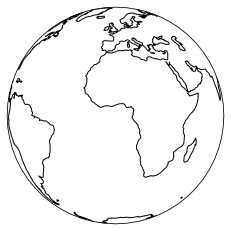

In [3]:
# Make sure we can plot a simple map with CartoPy
ortho = cartopy.crs.Orthographic()
fig = P.figure()
ax = fig.add_subplot(projection=ortho)
ax.coastlines()
fig.show()

## Adding plate polygons from Corelle

In [4]:
# Get plate polygons from Corelle
from requests import get


# API call returns GeoJSON format plates
res = get("https://birdnest.geology.wisc.edu/corelle/api/plates?model=Wright2013")
plate_features = res.json()

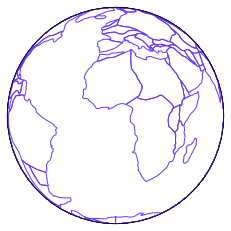

In [5]:
from shapely.geometry import shape

fig = P.figure()
ax = fig.add_subplot(projection=ortho)

geometries = [shape(f["geometry"]) for f in plate_features]
ax.add_geometries(geometries, crs=cartopy.crs.Geodetic(), edgecolor="#6638f0", facecolor='none')
fig.show()

## Adding pre-split feature layers

Corelle keeps some basic pre-split feature layers on the server for each plate model.

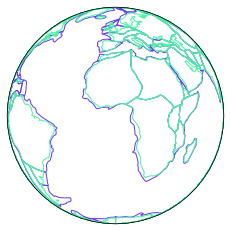

In [6]:
# API call returns GeoJSON format plates

coast_features = get("https://birdnest.geology.wisc.edu/corelle/api/feature/ne_110m_land?model=Wright2013").json()
geometries = [shape(f["geometry"]) for f in coast_features]
ax.add_geometries(geometries, crs=cartopy.crs.Geodetic(), edgecolor="#4af2a1", facecolor="none")
fig

### The structure of a plate feature

In [7]:
plate_features[0]

{'id': 202,
 'properties': {'id': 4217,
  'plate_id': 202,
  'young_lim': 0,
  'old_lim': 600.0,
  'name': 'Parana Basin Plate, South America'},
 'type': 'Feature',
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-54.3065697309999, -39.9785525659999],
     [-54.6479925589999, -40.312862418],
     [-62.2591400839999, -39.8864822829999],
     [-64.0420537629999, -39.4994955179999],
     [-64.2533767059999, -39.1296721709999],
     [-64.3400300739999, -37.3497015449999],
     [-64.0804546319999, -33.574621352],
     [-64.2536545009999, -32.1676300409999],
     [-63.8209610189999, -27.402604832],
     [-57.1066539129999, -29.6706413749999],
     [-55.1404348959999, -30.1981507899999],
     [-49.0062320319999, -31.7093648879999],
     [-51.7864551179999, -36.6206338939999],
     [-53.0331075599999, -38.0013349839999],
     [-53.5290875629999, -38.9932949909999],
     [-54.3065697309999, -39.9785525659999]]]]}}

# Applying rotations

## Get and apply rotations at 50 Ma

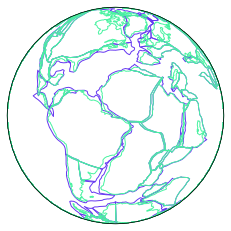

In [8]:
from corelle_helpers import rotate_features, rotate_geometry
import numpy as N
rotations = get("https://birdnest.geology.wisc.edu/corelle/api/rotate?model=Wright2013&time=120&quaternion=true").json()



fig = P.figure()
ax = fig.add_subplot(projection=ortho)

# Rotate our plate polygons
feat = list(rotate_features(rotations, plate_features))
ax.add_geometries(feat, crs=cartopy.crs.Geodetic(), edgecolor="#6638f0", facecolor='none')

# Rotate our coastline features
feat = list(rotate_features(rotations, coast_features))
ax.add_geometries(feat, crs=cartopy.crs.Geodetic(), edgecolor="#4af2a1", facecolor="none")
fig.show()

# Ongoing work: rotation time series

Here, we will try to use bulk rotation of features to build a global paleolatitude time series

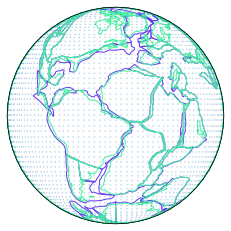

In [9]:
from geom_helpers import points_on_sphere

# Plot a (nearly) uniform distribution of points on a sphere
pt = points_on_sphere(5000)
ax.plot(pt[:, 0], pt[:, 1], "o", markersize=0.2, transform=cartopy.crs.Geodetic(), rasterized=True)
fig

In [ ]:
# TODO: create an index of plate polygons to match to features
plate_idx = {}

In [10]:
# Get all rotations through time
res = 

